# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.preprocessing import FunctionTransformer, Imputer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

#import custom module
from cluster import etl_pipeline as etl
from cluster.etl_pipeline import DummiesTransformer

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../Arvato-Capstone/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('../Arvato-Capstone/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [ ]:
#Shape and head of general data
print("General population shape {}.".format(azdias.shape))
azdias.head()

In [ ]:
azdias.describe()

In [ ]:
#Shape and head of customers data
print("Customers shape {}.".format(customers.shape))
customers.head()

In [ ]:
customers.describe()

## Preprocessing

### Assess Missing Data

#### Create missing value keys dictionary from 'DIAS Attributs - Values 2017.xlsx'

 - 1. 'DIAS Attributes - Values 2017.xlsx' file was converted to csv file 'DIAS_Attributes_Values_2017.csv'. 
 - 2. create_missing_code_dict function is created to create dictionary of missings keys for attributes


In [4]:
missing_keys_dict = etl.create_missing_key_dict("./data/DIAS_Attributes_Values_2017.csv")

#assess initially missing data
ini_missing = etl.get_missing_by_column(azdias)

#### Convert Missing Value Codes to NaNs

In [5]:
etl.convert_keys_to_nan(azdias, missing_keys_dict)

Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.


Note that note all attributes that are listed in DIAS_Attributes_Values_2017 file are present in AZDIAS dataset

#### Assess Missing Data in Each Column

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
sorted_missing_info = etl.create_missing_info_df(azdias, ini_missing)
print(sorted_missing_info.round(2)[:20])

                  Attribute  ini_missing  final_missing  percent_missing
7               ALTER_KIND4       890016         890016            99.86
349                TITEL_KZ       889061         889061            99.76
6               ALTER_KIND3       885051         885051            99.31
33         D19_BANKEN_LOKAL       874745         874745            98.15
5               ALTER_KIND2       861722         861722            96.69
43           D19_DIGIT_SERV       857661         857661            96.23
41             D19_BIO_OEKO       854074         854074            95.83
79          D19_TIERARTIKEL       852220         852220            95.62
63   D19_NAHRUNGSERGAENZUNG       852176         852176            95.62
47               D19_GARTEN       851626         851626            95.56
60         D19_LEBENSMITTEL       837914         837914            94.02
95        D19_WEIN_FEINKOST       836142         836142            93.82
45              D19_ENERGIE       829857         82

Distribution of missing values in AZDIAS dataset


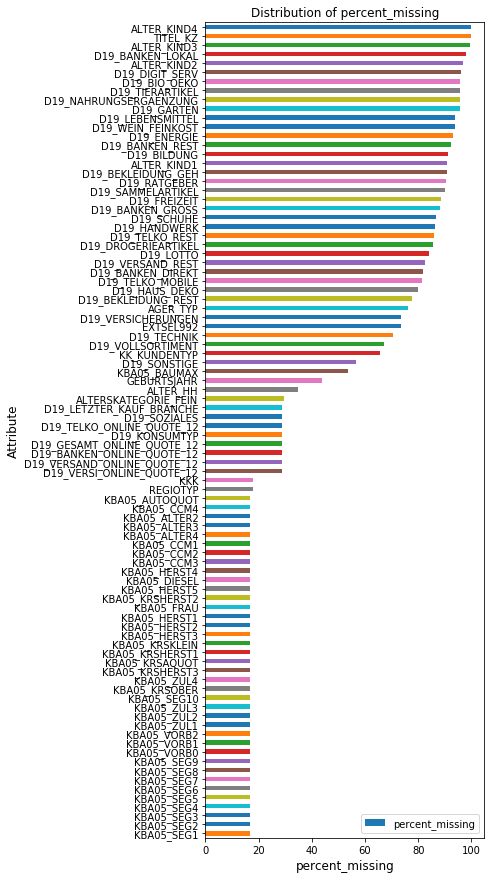

In [7]:
#plot barh plot of final missing values in Azdias
print("Distribution of missing values in AZDIAS dataset")
etl.plot_attribute_distribution(sorted_missing_info, "Attribute", "percent_missing", 90)

In [8]:
#print attributes with more than 30% percent of missing data
deleted_columns_1 = sorted_missing_info[sorted_missing_info["percent_missing"]>30]["Attribute"].values
print (len(deleted_columns_1))
print (list(deleted_columns_1))
print (sorted_missing_info[sorted_missing_info["percent_missing"]>30]["percent_missing"].values.round(2))

41
['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
[99.86 99.76 99.31 98.15 96.69 96.23 95.83 95.62 95.62 95.56 94.02 93.82
 93.11 92.21 91.24 90.9  90.81 90.33 90.   88.73 88.12 86.74 86.22 85.95
 85.39 83.92 82.41 81.78 81.55 80.01 77.7  76.02 73.46 73.4  70.7  67.32
 65.6  56.77 53.47 44.02 34.81]


In this step I have identified the columns with missing values (np.NaN). The analysis demonstrates that most of the columns have less than 30% of missing data while there are 41 attributes with more than 30% of missing data. Among these attributes are 'ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'. These 41 attributes will be dropped from analysis.


Besides that, the attributes with similar amount of missing data were identified:
    
    158064  (%17.74): KKK, REGIOTYP
    148115 (%16.62):  most of KBA_05 features
    133324 (%14.96): all RR3 micro-cell features (KBA05_ANTG3, KBA05_ANTG1, KBA05_ANTG2, KBA05_GBZ, KBA05_ANTG4, MOBI_REGIO) 
    116515 (%13.07): all PLZ8 macro-cell features (PLZ8_ANTG2, PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ)
    111196 missing by code (%12.48): VERS_TYP, SHOPPER_TYP, HEALTH_TYP
    SEMIO_, FINANZ_, AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, GEBURTSJAHR, GREEN_AVANTGARDE,
    HEALTH_TYP, NATIONALITAET_KZ and PRAEGENDE_JUGENDJAHRE attributes with zero missing features.

#### Drop columns####
Drop columns with more than 30% percent of missing values listed in list of deleted_columns (41 coulmns) need to be dropped.

Additionally we will drop the columns that are unique, categorical with more than 10 categories (however we will keep CAMEO_INTL_2015), binary with more than 70 percent of one value, with repetition from another feature, and some attributes which do not have explanation in info file.   


To identified these columns I have created attribute_types.csv file where type and action with each of attributes is addressed. Also the type for missing discription attributes that is not similar to any listed attributes is taken as categorical. These unknown atributes are listed with question mark infront of type.
    

In [4]:
att_type = pd.read_csv('./data/attribute_types.csv', sep=',')
att_type.head()

#attributes that needs to be dropped
deleted_columns_2 = att_type[att_type["action"].isin(["drop"])]["attribute"].values
print("Additional attributes that needs to be dropped: \n"
      "{}.".format(deleted_columns_2))
print("")


Additional attributes that needs to be dropped: 
['LNR' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_TITEL' 'CAMEO_DEU_2015'
 'GEBAEUDETYP' 'GEBURTSJAHR' 'KBA05_MODTEMP' 'LP_FAMILIE_FEIN'
 'LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'LP_STATUS_FEIN' 'PLZ8_ANTG1'
 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'VERDICHTUNGSRAUM' 'VK_DHT4A'
 'VK_DISTANZ' 'VK_ZG11' 'ALTERSKATEGORIE_FEIN' 'D19_TELKO_ONLINE_QUOTE_12'
 'D19_LETZTER_KAUF_BRANCHE' 'D19_VERSI_ONLINE_QUOTE_12'].



In [10]:
deleted_columns = list(deleted_columns_1) + list(deleted_columns_2)
print("List of columns that wiil be deleted: \n{}.".format(deleted_columns))

List of columns that wiil be deleted: 
['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_BANKEN_REST', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_VERSICHERUNGEN', 'EXTSEL992', 'D19_TECHNIK', 'D19_VOLLSORTIMENT', 'KK_KUNDENTYP', 'D19_SONSTIGE', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'LNR', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'CAMEO_DEU_2015', 'GEBAEUDETYP', 'GEBURTSJAHR', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_A

In [11]:
#drop columns with more than 30% of missing data
print(azdias.shape)
azdias_reduced = azdias.drop(deleted_columns,axis=1)
print(azdias_reduced.shape)


(891221, 366)
(891221, 302)


#### Assess Missing Data in Each Row

In [12]:
# How much data is missing in each row of the dataset?
azdias_reduced['n_missing'] = azdias_reduced.isnull().sum(axis=1)
#print("First 20 rows with the highest missing values: \n", azdias['n_missing'].sort_values(ascending=False)[:20])
print(azdias_reduced['n_missing'].describe())


count    891221.000000
mean         30.869677
std          70.906169
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max         233.000000
Name: n_missing, dtype: float64


Text(0,0.5,'Number of rows')

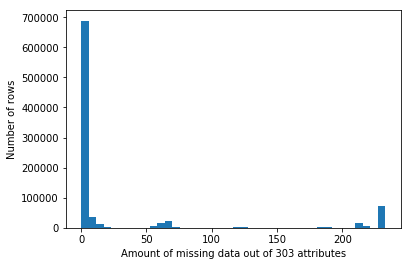

In [13]:
ax = azdias_reduced["n_missing"].plot(kind='hist', bins=40)
ax.set_xlabel("Amount of missing data out of {} attributes".format(azdias_reduced.shape[1]))
ax.set_ylabel("Number of rows")

In [14]:
#divide the data into two subsets based on the number of missing
# values in each row.
#We will separate at 25 missing attributes
azdias_few_nan = azdias_reduced[azdias_reduced["n_missing"]<= 25].drop("n_missing", axis=1)
azdias_nan = azdias_reduced[azdias_reduced["n_missing"]> 25].drop("n_missing", axis=1)

print(azdias_few_nan.shape)
print(azdias_nan.shape)

(737235, 302)
(153986, 302)


Comparison of distribution of values for columns where there are no missing values between No NaN and droped NaN subsets.


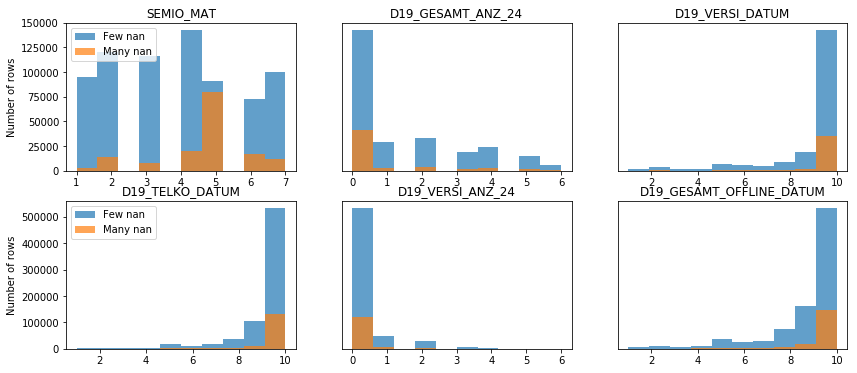

In [15]:
# Compare the distribution of values for at least six columns where there are
# no or few missing values, between the two subsets.
#list of attributes with no missing values
attribute_list  = sorted_missing_info[sorted_missing_info['final_missing']<200]['Attribute'].values
#print(attribute_list)

print("Comparison of distribution of values for columns where there are no missing values between No NaN and droped NaN subsets.")
etl.plot_distribution_comparison(azdias_few_nan, "Few nan", azdias_nan, "Many nan", attribute_list) 

The maximum number of missing data in each row is 233 attributes out of 303 attributes. The distribution of amount of missing data in each row demonstrates that mosst of the rows has less than 25 missing attribute. So, the data was devided into two subsets: azdias_few_nan with <=25 missing attributes (737235 rows) and azdias_nan with >25 missing attributes ( 153986 rows). Comparison of distribution of values for 6 randomly choosen columns demonstrates that there is similar distribution in two data_sets with few missing values (Few Nans) and a lot of NaNs (Nans) 

[ZABEOTYP, D19_GESAMT_ANZ_24, D19_KINDERARTIKEL, D19_VERSAND_ONLINE_DATUM, FINANZ_VORSORGER and D19_GESAMT_ONLINE_DATUM]

### Clean and enginner new features using clean function###

#### Attributes that needs engineering####
Engineering of these attributes was included in clean_data function

In [5]:
engineered_attributes = list(np.intersect1d(att_type[att_type["action"].isin(["engineering"])]["attribute"].values, azdias.columns))
print("Attributes that need engineering: \n"
      "{}.".format(engineered_attributes))
print("")


Attributes that need engineering: 
['CAMEO_INTL_2015', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'].



In [6]:
azdias_cleaned = etl.clean_data(azdias)
azdias_cleaned.shape

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
Remove rows with more than 25 missing attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
(737235, 302)
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX


(737235, 305)

### Select different types of data

Identify attributes that correspond to different types:

- log_transform attributes (numeric continuous attributes with skew_value >1.0  that need log transform)
- binary_attributes
- categorical_attributes (one hot encode required)
- numeric_attributes (numeric interval data,  ordinal(make the simplifying assumption that the ordinal variables can be treated as being interval in nature)



Continuous attributes distribution ['ANZ_HAUSHALTE_AKTIV' 'ANZ_PERSONEN' 'EINGEZOGENAM_HH_JAHR'
 'KBA13_ANZAHL_PKW' 'MIN_GEBAEUDEJAHR']
ANZ_HAUSHALTE_AKTIV skew_value = 8.73402870740657.


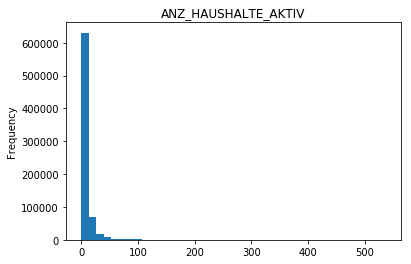

ANZ_PERSONEN skew_value = 1.7651843121005266.


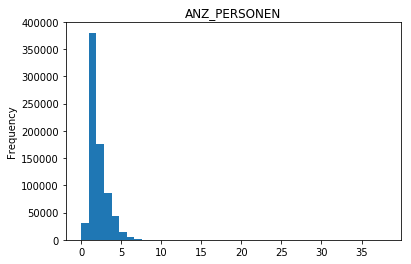

EINGEZOGENAM_HH_JAHR skew_value = 0.22025109510697183.


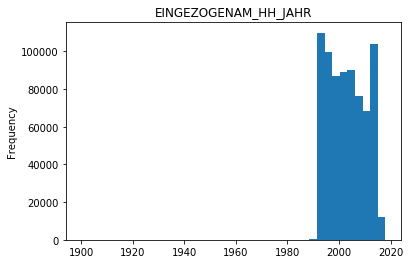

KBA13_ANZAHL_PKW skew_value = 1.265253431219012.


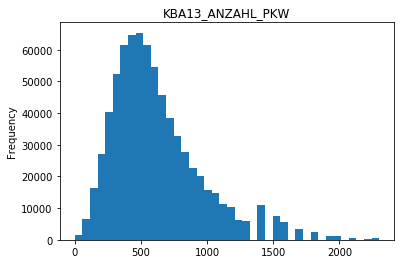

MIN_GEBAEUDEJAHR skew_value = 3.063678733216271.


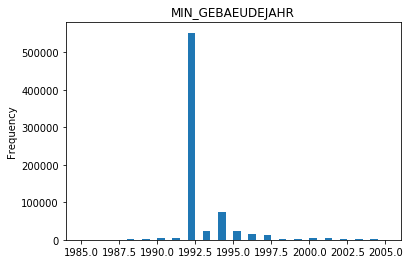

Numerical attributes that need to be log transformed: 
['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'].

Binary attributes: 
['DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_SEG6', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'ANREDE_KZ', 'MOVEMENT', 'RURAL_NEIGHBORHOOD', 'PLZ8_BAUMAX_BUSINESS'].

Categorical attributes that need to be Re-Encoded: 
['AKT_DAT_KL', 'ARBEIT', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA13_BAUMAX', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SHOPPER_TYP', 'STRUKTURTYP', 'UMFELD_ALT', 'VHA', 'ZABEOTYP'].



In [7]:
log_attributes, bin_attributes, cat_attributes, num_attributes = etl.select_attributes_by_type(azdias_cleaned)

print("Numerical attributes that need to be log transformed: \n"
      "{}.".format(log_attributes))
print("")

print("Binary attributes: \n"
      "{}.".format(bin_attributes))
print("")

print("Categorical attributes that need to be Re-Encoded: \n"
      "{}.".format(cat_attributes))
print("")



### ETL Pipeline ###
- log_attributes: log -> impute median -> standard scaler
- bin_attributes: impute most frequent
- cat_attributes: dummies transformer (keep all dummy columns, missing values are zeros)
- num_attributes: impute median -> standard scaler

#### log_attributes pipeline ###

In [8]:
log_transform = ('log_transform', FunctionTransformer(np.log1p, validate=False))
log_impute = ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
log_scale = ('log_scale', StandardScaler())

log_pipeline = Pipeline([log_transform, log_impute, log_scale])


####  Binary attributes pipeline ###

In [9]:
binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

#### Categorical attributes pipeline ###

In [10]:
cat_pipeline = Pipeline([('cat_dummy', etl.DummiesTransformer())])

#### Numerical Attributes Pipeline ###

In [11]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
num_scale = ('num_scale', StandardScaler())

num_pipeline = Pipeline([num_impute, num_scale])

#### Combining all column transformations

In [12]:
transformers = [('log', log_pipeline, log_attributes),
                ('binary', binary_pipeline, bin_attributes),
                ('cat', cat_pipeline, cat_attributes),
                ('num', num_pipeline, num_attributes)]

ct = ColumnTransformer(transformers=transformers)

azdias_transformed = ct.fit_transform(azdias_cleaned)
azdias_transformed.shape

(737235, 410)

In [14]:
#obtain dummies column names
pl = ct.named_transformers_['cat']
cd = pl.named_steps['cat_dummy']
dummies_names = list(cd.get_feature_names())

#all columns for transformed data
column_names = list(log_attributes)+list(bin_attributes)+dummies_names+list(num_attributes)

#create transformed DataFrame
azdias_transformed = pd.DataFrame(azdias_transformed, columns = column_names)

In [16]:
print("All columns are numeric = {}".format(etl.check_columns_numeric(azdias_transformed)))
azdias_transformed.describe()

All columns are numeric = True


,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,...,SEMIO_VERT,UMFELD_JUNG,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,ALTERSKATEGORIE_GROB,GENERATION_DECADE,WEALTH,LIFE_AGE,PLZ8_BAUMAX_FAMILY
count,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,737235.000000,737235.000000,737235.00000,737235.000000,737235.000000,737235.000000,...,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05,7.372350e+05
mean,-1.177310e-15,-1.603202e-16,-2.773428e-15,1.671020e-12,0.989195,0.223602,0.09074,0.118951,0.236927,0.789763,...,-2.291807e-15,-3.215782e-15,6.465103e-15,1.796641e-14,-3.260760e-15,6.080414e-16,1.900087e-15,1.007804e-14,-1.741958e-15,1.050926e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.103385,0.416658,0.28724,0.323731,0.425198,0.407477,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.896013e+00,-2.412959e+00,-1.112358e+01,-4.248870e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,-1.679638e+00,-2.711424e+00,-2.085911e+00,-1.865133e+00,-3.687983e+00,-1.682068e+00,-2.292298e+00,-1.560679e+00,-1.258111e+00,-1.294381e+00
25%,-6.831911e-01,-6.150039e-01,-5.807664e-01,-3.893518e-01,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,-1.161781e+00,-9.086758e-01,-3.550289e-01,-6.892201e-01,1.831876e-02,-7.570140e-01,-9.038994e-01,-8.770721e-01,-1.258111e+00,-3.156559e-01
50%,-1.192610e-01,-6.150039e-01,4.765952e-02,-3.893518e-01,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,3.917930e-01,-7.301616e-03,-3.550289e-01,-1.012637e-01,5.477904e-01,1.680402e-01,-2.097000e-01,4.901421e-01,8.779949e-02,-3.156559e-01
75%,6.459444e-01,4.367321e-01,6.604993e-01,-3.893518e-01,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,...,9.096508e-01,8.940726e-01,5.104123e-01,1.074649e+00,5.477904e-01,1.093094e+00,1.178699e+00,1.173749e+00,7.607546e-01,-3.156559e-01
max,5.043465e+00,7.089955e+00,2.585413e+00,6.742495e+00,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.427509e+00,8.940726e-01,1.375854e+00,1.074649e+00,5.477904e-01,5.718365e+00,1.178699e+00,1.173749e+00,1.433710e+00,2.620521e+00


### Check outliers in numerical and log transformed attributes###
Use Tukey rule to detect and remove outliers outside of the InterQuartile range (IQR): IQR = Q3 - Q1

In [45]:
#new data frame without outliers
azdias_outlier_removed = azdias_transformed.copy()

outlier_attributes = log_attributes#np.append(log_attributes, num_attributes) 

#dictionary of number of outlier by column_name
outlier_attributes_dict = {}
#print(azdias_outlier_removed.shape)

for column in outlier_attributes:
    previous_len = azdias_outlier_removed.shape[0]
    azdias_outlier_removed = etl.tukey_rule(azdias_outlier_removed, column)
    outlier_attributes_dict[column] = previous_len - azdias_outlier_removed.shape[0] 
    #print(azdias_outlier_removed.shape)
    
outlier_attributes_dict

(737235, 410)
 


{'ANZ_HAUSHALTE_AKTIV': 9232,
 'ANZ_PERSONEN': 50952,
 'KBA13_ANZAHL_PKW': 11606,
 'MIN_GEBAEUDEJAHR': 164818}

There are too many outlier. These outliers will be kept, otherwise more than 30% of data will be lost.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA 

In [46]:
# Apply PCA to the data.
print("Current number of features: ", azdias_transformed.shape[1])
pca = PCA()
azdias_pca = pca.fit_transform(azdias_transformed)
#sum(pca.explained_variance_ratio_)
etl.scree_plot(pca)

Current number of features:  410


There is a visual reduction in explained variance after ~225 principal components

In [72]:
n_components = 175
print("Explained variance ratio for the first {} components is {}%.".
      format(n_components, sum(pca.explained_variance_ratio_[:n_components]).round(2)*100))

Explained variance ratio for the first 175 components is 91.86718963614973%.


In [73]:
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_transformed)
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio)

print(azdias_pca.shape)



Explained variance ratio: 0.9177267672581478
(737235, 175)


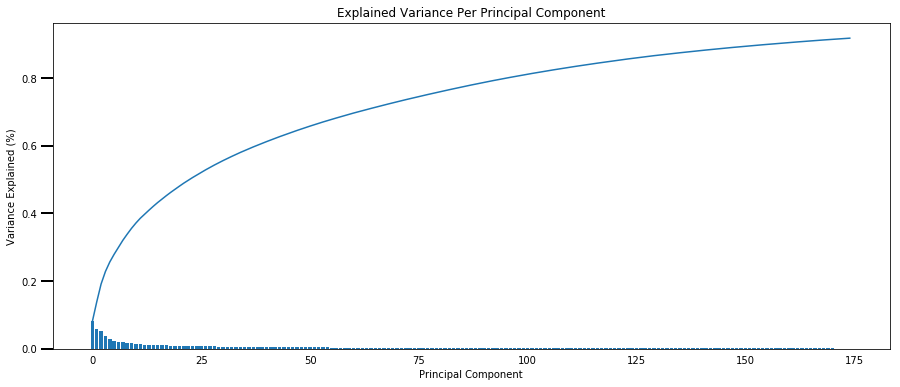

In [74]:
etl.scree_plot(pca)

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def map_component_to_features(component):
    '''
    Map weights for the component number to corresponding feature names
    '''
    #print(pd.DataFrame(pca.components_[1]**2*100,index=azdias_test_cleaned.columns,columns=['w']).sort_values(by='w',ascending=False).round(2))
    #return pd.DataFrame(pca.components_[component]**2*100,index=azdias_cleaned.columns,columns=['weight']).sort_values(by='weight',ascending=False).round(2)
    return pd.DataFrame(pca.components_[component],index=azdias_cleaned.columns,columns=['weight']).sort_values(by='weight',ascending=False).round(2)

print("Variance of first component:", pca.explained_variance_ratio_[0].round(2)*100)
print(map_component_to_features(0))

#The most prominent features are ANZ_HAUSHALTE_AKTIV.0, CAMEO_DEUG_2015, HH_EINKOMMEN_SCORE, KBA13_ANTG3-4  
#The most prominent negative features are MOBI_REGIO, KBA13_ANTG1, KBA05_ANTG1
# So, the first principal component is associated with size, wealth and type of family, larger family, 
# higher component corresponds to working class, larger  family and also poorer family, 
#From negative values: higher magnitide of component, lower financial interest


Variance of first component: 7.0
                            weight
ANZ_HAUSHALTE_AKTIV           0.14
CAMEO_DEUG_2015               0.14
HH_EINKOMMEN_SCORE            0.14
KBA13_ANTG3                   0.14
KBA13_ANTG4                   0.14
ORTSGR_KLS9                   0.11
EWDICHTE                      0.11
FINANZ_HAUSBAUER              0.11
WEALTH                        0.10
KBA13_HALTER_30               0.10
KBA05_ANTG4                   0.09
KBA13_BAUMAX_5.0              0.09
KBA05_ANTG3                   0.09
KBA13_HALTER_35               0.09
ARBEIT_4.0                    0.08
PLZ8_BAUMAX_BUSINESS          0.08
RELAT_AB                      0.08
ANZ_STATISTISCHE_HAUSHALTE    0.08
CJT_TYP_2                     0.08
D19_KONSUMTYP_MAX             0.08
KBA13_ALTERHALTER_30          0.08
STRUKTURTYP_3.0               0.08
D19_GESAMT_DATUM              0.08
KONSUMZELLE                   0.08
D19_VERSAND_DATUM             0.07
FINANZ_SPARER                 0.07
KBA13_ANTG2           

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print("Variance of second component:", pca.explained_variance_ratio_[1].round(2)*100)
print(map_component_to_features(1))

#The most prominent features are ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3
#The most prominent negative features are GENERATION_DECADE, FINANZ_SPARER
# So, the second principal component is associated with age. Older people has higher component value
#From negative values: higher component has lower generation decade (which is similarly to higher age)
#and higher probability of people being money savers 

Variance of second component: 5.0
                             weight
GENERATION_DECADE              0.20
CJT_TYP_1                      0.18
CJT_TYP_2                      0.18
FINANZ_SPARER                  0.18
FINANZ_UNAUFFAELLIGER          0.16
ONLINE_AFFINITAET              0.16
GEBURTSJAHR                    0.15
SEMIO_PFLICHT                  0.15
SEMIO_TRADV                    0.15
FINANZ_ANLEGER                 0.15
SEMIO_REL                      0.14
SEMIO_RAT                      0.13
D19_GESAMT_ANZ_24              0.12
D19_GESAMT_ANZ_12              0.11
RT_KEIN_ANREIZ_5.0             0.11
D19_GESAMT_ONLINE_QUOTE_12     0.10
D19_VERSAND_ANZ_24             0.10
D19_VERSAND_ONLINE_QUOTE_12    0.10
ZABEOTYP_4                     0.10
SEMIO_KULT                     0.10
D19_VERSAND_ANZ_12             0.10
SEMIO_MAT                      0.09
EINGEZOGENAM_HH_JAHR           0.08
SEMIO_FAM                      0.07
D19_BANKEN_ANZ_24              0.07
RT_UEBERGROESSE_4.0           

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print("Variance of third component:", pca.explained_variance_ratio_[2].round(2)*100)
print(map_component_to_features(2))


#The most prominent features are SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, SEMIO_KULT
#The most prominent negative features are ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM
# So, the third component is associated with gender and type of personality, more dreamful and family oriented people 
# has higher component value
#From negative values: higher magnitude of the component the higher probability of people being male with combative attitude


Variance of third component: 5.0
                             weight
KBA13_HERST_BMW_BENZ           0.18
KBA13_SEG_OBEREMITTELKLASSE    0.16
KBA13_MERCEDES                 0.15
KBA13_BMW                      0.15
KBA13_SITZE_4                  0.15
KBA13_SEG_SPORTWAGEN           0.14
KBA13_KMH_211                  0.12
KBA13_SEG_OBERKLASSE           0.12
KBA05_HERST1                   0.12
KBA13_KMH_250                  0.12
KBA13_KW_121                   0.12
EWDICHTE                       0.12
KBA13_CCM_2501                 0.12
KBA05_KW3                      0.11
KBA13_CCM_3000                 0.11
KBA13_KRSHERST_BMW_BENZ        0.10
ORTSGR_KLS9                    0.10
KBA13_CCM_3001                 0.10
KBA05_MOTOR                    0.10
OST_WEST_KZ                    0.10
STRUKTURTYP_3.0                0.10
KBA05_CCM4                     0.10
KBA05_MOD1                     0.10
KBA13_HALTER_65                0.10
KBA05_SEG5                     0.09
KBA13_CCM_2500                 

### Clustering

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29


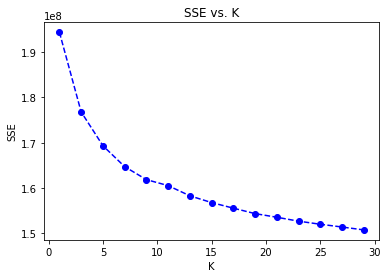

In [75]:
# visualize within-cluster distance across number of clusters.

#batch size of minibatch
batch_size=50000

scores = []
centers = list(range(1,30, 2))
for center in centers:
    print(center)
    scores.append(etl.get_kmeans_score(azdias_pca, center, batch_size))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

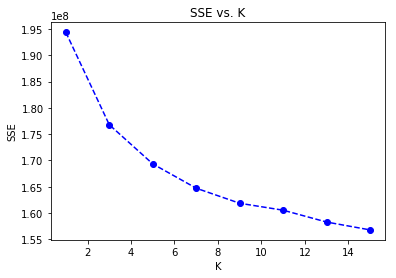

In [83]:
plt.plot(centers[:8], scores[:8], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 15
print("The selected number of clusters:", n_clusters)
kmeans = MiniBatchKMeans(n_clusters, batch_size, random_state=42)
general_model = kmeans.fit(azdias_pca)
general_predictions = kmeans.predict(azdias_pca)

The selected number of clusters: 15


### Combine ETL pipeline with PCA and KMeans steps


In [85]:
n_clusters = 15
batch_size = 50000
unsupervised_pipeline = Pipeline([
                        ('transform', ct), 
                        ('pca', PCA(n_components),
                        ('kmeans', MiniBatchKMeans(n_clusters, batch_size, random_state=42) )
                        )])

In [87]:
customers_cleaned = etl.clean_data(customers)

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
Remove rows with more than 25 missing attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
(134245, 302)
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX


In [90]:
customers_transformed = unsupervised_pipeline.transform(customers_cleaned)
print(customers_transformed.shape)
customers_transformed = pd.DataFrame(customers_transformed, columns = column_names)
customers_transformed.head()

ValueError: too many values to unpack (expected 2)

In [108]:
customers_predictions = kmeans.predict(customers_pca)
print(customers_predictions)

[ 3  3  3 ...,  3 14  1]


In [109]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

dfbar = pd.DataFrame(columns=['clusters','type'])
dfbar['clusters'] = np.append(general_predictions, customers_predictions)
dfbar['type'] = ['general']*len(general_predictions) + ['customers']*len(customers_predictions)
#sns.countplot(x='clusters', hue='type', data=dfbar)

In [110]:
general_counts = np.array(dfbar['clusters'].loc[dfbar['type'] == 'general'].value_counts().sort_index(ascending=True))
customers_counts = np.array(dfbar['clusters'].loc[dfbar['type'] == 'customers'].value_counts().sort_index(ascending=True))

print("General counts:", general_counts)
print("Customers counts:", customers_counts)

#"add zero customers to 13 cluster"
#customers_counts = np.append(customers_counts, customers_counts[-1])
#customers_counts[-2] = 0
#print(customers_counts)

general_ratio = general_counts/len(general_predictions)
customers_ratio = customers_counts/len(customers_predictions)
print("General ratio:", general_ratio)
print("Customers ratio:", customers_ratio)

General counts: [33396 48893 46672 64307 54478 55319 57532 49362 39712 46174 44588 59536
 50590 36715 49957]
Customers counts: [ 4894 15663   482 30140  4702 18404 14765  5179   878   994 29009   564
  2723  2288  3560]
General ratio: [ 0.04529923  0.06631978  0.06330716  0.08722775  0.07389543  0.07503618
  0.07803796  0.06695595  0.05386643  0.06263166  0.06048037  0.08075624
  0.06862164  0.04980122  0.06776302]
Customers ratio: [ 0.03645573  0.11667474  0.00359045  0.22451488  0.03502551  0.13709263
  0.10998547  0.03857872  0.00654028  0.00740437  0.21608998  0.00420127
  0.02028381  0.01704347  0.02651868]


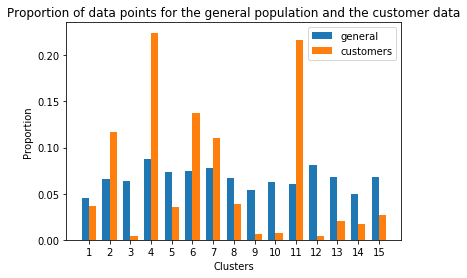

In [111]:
index = np.arange(n_clusters)
bar_width = 0.35

fig, ax = plt.subplots()

#print(len(customers_ratio))
ax.bar(index, general_ratio, bar_width, label = "general")
ax.bar(index+bar_width, customers_ratio, bar_width, label = "customers")

ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of data points for the general population and the customer data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index+1)
ax.legend()

#fig.tight_layout()
plt.show()

15
15


[Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7'),
 Text(0,0,'8'),
 Text(0,0,'9'),
 Text(0,0,'10'),
 Text(0,0,'11'),
 Text(0,0,'12'),
 Text(0,0,'13'),
 Text(0,0,'14'),
 Text(0,0,'15')]

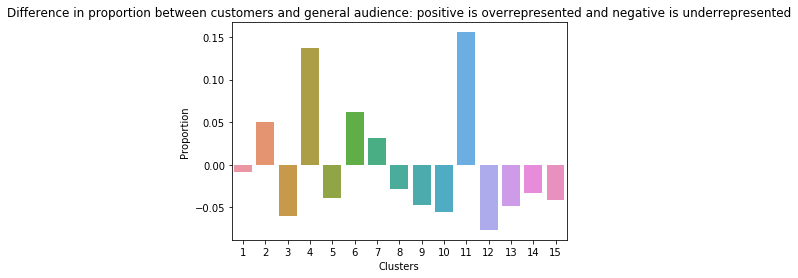

In [112]:
#plot the difference in proportion between customers and general audience.
#positive - overrepresented customers data
#negative - underrepresented customers data
diff_ratio = customers_ratio - general_ratio
print(len(diff_ratio))
index = np.arange(n_clusters)
bar_width = 0.35
print(len(index))
fig, ax = plt.subplots()

ax = sns.barplot(x = index, y = diff_ratio)

ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion')
ax.set_title('Difference in proportion between customers and general audience: positive is overrepresented and negative is underrepresented')
ax.set_xticks(index)
ax.set_xticklabels(index+1)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [104]:
mailout_train = pd.read_csv('../Arvato-Capstone/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
print(mailout_train.shape)
mailout_train["RESPONSE"].value_counts()

(42962, 367)


0    42430
1      532
Name: RESPONSE, dtype: int64

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
(42962, 367)
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
(42962, 304)
(42962, 304)
Re-encode categorical attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
(42962, 409)
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX
All columns are numeric
(42962, 412)


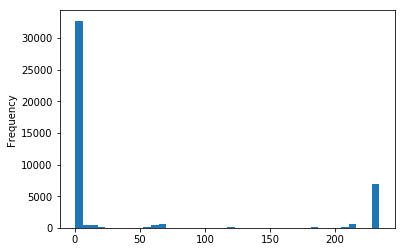

In [107]:
#clean data using clean_data function from unsupervied learning created for general population
mailout_train_cleaned = clean_data(mailout_train, test_data=True)

In [103]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(mailout_train_cleaned, mailout_train_cleaned["RESPONSE"]):
    strat_train_set = mailout_train_cleaned.loc[train_index]
    strat_test_set = mailout_train_cleaned.loc[test_index]

print(mailout_train_cleaned["RESPONSE"].value_counts()/mailout_train_cleaned.shape[0])
print(strat_train_set["RESPONSE"].value_counts()/strat_train_set.shape[0])
print(strat_test_set["RESPONSE"].value_counts()/strat_test_set.shape[0])

0    0.987705
1    0.012295
Name: RESPONSE, dtype: float64
0.0    0.779186
1.0    0.009716
Name: RESPONSE, dtype: float64
0.0    0.777039
1.0    0.010047
Name: RESPONSE, dtype: float64


/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [94]:
y_train = strat_train_set["RESPONSE"]
X_train = strat_train_set.drop(["RESPONSE"], axis=1)

In [95]:
log_transform_attributes = ['ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW']
transformer = FunctionTransformer(np.log1p, validate=False)
X_train[log_transform_attributes] = transformer.transform(X_train[log_transform_attributes])

imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
X_train = imputer.fit_transform(X_train[:])

scaler = scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[:])


In [69]:
X_train

array([[-0.82496267, -0.00910611, -0.34618162, ...,  1.85468748,
        -0.29630846, -0.26589165],
       [-0.82496267,  4.0136167 , -0.34618162, ..., -0.53917439,
        -0.29630846, -0.26589165],
       [-0.82496267, -0.00910611, -0.34618162, ..., -0.53917439,
        -0.29630846, -0.26589165],
       ..., 
       [-0.82496267,  1.59998301, -0.34618162, ...,  1.85468748,
        -0.29630846, -0.26589165],
       [-0.34728116,  0.79543845, -0.26960416, ..., -0.53917439,
        -0.29630846, -0.26589165],
       [ 0.65092685, -1.61819523,  0.18986058, ..., -0.53917439,
        -0.29630846,  2.07970133]])

In [96]:
y_test = strat_test_set["RESPONSE"]
X_test = strat_test_set.drop(["RESPONSE"], axis=1)

In [97]:
X_test[log_transform_attributes] = transformer.transform(X_test[log_transform_attributes])

X_test = imputer.transform(X_test[:])
X_test = scaler.transform(X_test[:])

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=42)
clf_B = AdaBoostClassifier(random_state=42)
clf_C = GradientBoostingClassifier(random_state=42)
#clf_D = SVC(random_state=42)


In [99]:
from sklearn.metrics import roc_auc_score

for clf in [clf_A, clf_B, clf_C]:
    print(clf)
    clf.fit(X_train, y_train)
    proba_train = clf.predict_proba(X_train)[:, 1]
    proba_test = clf.predict_proba(X_test)[:, 1]
    print("Roc_auc train score {}".format(roc_auc_score(y_train, proba_train)))
    print("Roc_auc test score {}".format(roc_auc_score(y_test, proba_test)))



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [74]:
from sklearn.model_selection import GridSearchCV

#initialize classifier
clf = GradientBoostingClassifier(random_state=42)
#parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'learning_rate': [0.1], 'n_estimators': [100, 200], 
              'max_depth': [3], 'min_samples_split': [2]}

#scorer = make_scorer(score_func=roc_auc_score, needs_proba=True)

grid_obj = GridSearchCV(clf, parameters, scoring = 'roc_auc')

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator and predict
best_clf = grid_obj.best_estimator_
print(best_clf)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict_proba(X_test)[:, 1]

#best predictions
best_predictions = best_clf.predict_proba(X_test)[:, 1]

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Roc_auc score on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final Roc_auc score on the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
Unoptimized model
------
Roc_auc score on testing data: 0.7661

Optimized Model
------
Final Roc_auc score on the testing data: 0.7661


In [75]:
grid_obj.best_params_



{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

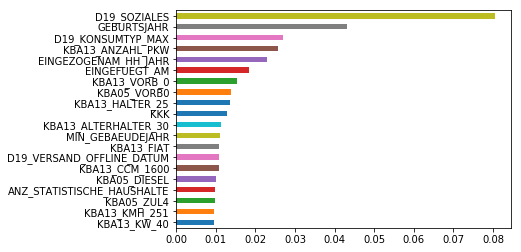

In [76]:
feature_importances = best_clf.feature_importances_

pd.Series(feature_importances, index=mailout_train_cleaned.drop(["RESPONSE"], axis=1).columns).sort_values()[-20:].plot(kind='barh')


In [77]:
#dump model
#from sklearn.externals import joblib

#joblib.dump(best_clf, 'batch1_gradboost.pkl')


import pickle

# Save to file in the current working directory
pkl_filename = "batch02_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)


### Use whole train set to train model for the next step###/

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
(42962, 367)
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
(42962, 304)
(42962, 304)
Re-encode categorical attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
(42962, 409)
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX
All columns are numeric
(42962, 412)
(42962, 4

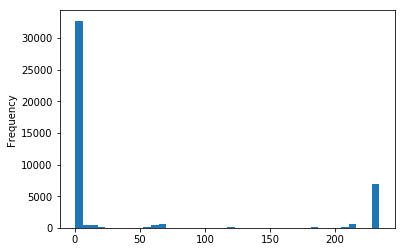

In [108]:
mailout_train_cleaned = clean_data(mailout_train, test_data=True)
print(mailout_train_cleaned.shape)

In [109]:
y_train = mailout_train_cleaned["RESPONSE"]
X_train = mailout_train_cleaned.drop(["RESPONSE"], axis=1)

In [110]:
log_transform_attributes = ['ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW']
transformer = FunctionTransformer(np.log1p, validate=False)
X_train[log_transform_attributes] = transformer.transform(X_train[log_transform_attributes])

imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
X_train = imputer.fit_transform(X_train[:])

scaler = scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[:])

In [111]:
#initialize classifier
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)
proba_train = clf.predict_proba(X_train)[:, 1]
print("Roc_auc train score {}".format(roc_auc_score(y_train, proba_train)))

Roc_auc train score 0.8946312280819891


In [112]:
# Save to file in the current working directory
pkl_filename = "batch03_whole_train_set_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(clf, file)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [113]:
mailout_test = pd.read_csv('../Arvato-Capstone/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
mailout_test.shape

(42833, 366)

Convert missing value codes into NaNs
Attribute BIP_FLAG is not available in DataFrame.
Attribute CAMEO_DEUINTL_2015 is not available in DataFrame.
Attribute D19_KK_KUNDENTYP is not available in DataFrame.
Attribute GEOSCORE_KLS7 is not available in DataFrame.
Attribute HAUSHALTSSTRUKTUR is not available in DataFrame.
Attribute KBA13_CCM_1400_2500 is not available in DataFrame.
Attribute SOHO_FLAG is not available in DataFrame.
Attribute WACHSTUMSGEBIET_NB is not available in DataFrame.
Attribute D19_BUCH is not available in DataFrame.
Attribute D19_KINDERARTIKELD19_KOSMETIK is not available in DataFrame.
(42833, 366)
Drop columns with more than 30% of missing values
Drop columns indicated in attribute_types.csv file
(42833, 303)
(42833, 303)
Re-encode categorical attributes
Reencode OST_WEST_KZ attribute
Change EINGEFUEGT_AM to year
(42833, 408)
Engineer PRAEGENDE_JUGENDJAHRE
Engineer CAMEO_INTL_2015
Engineer WOHNLAGE
Engineer PLZ8_BAUMAX
All columns are numeric
(42833, 411)


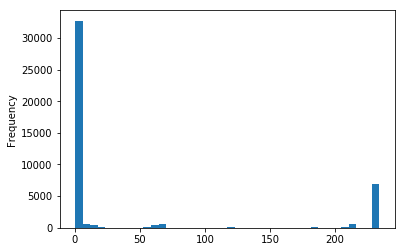

In [115]:
mailout_test_cleaned = clean_data(mailout_test, test_data=True)


In [116]:
# get missing columns in the Customer set
missing_columns = set(mailout_train_cleaned.drop(["RESPONSE"], axis=1).columns ) - set(mailout_test_cleaned.columns )

print(missing_columns)

# Add a missing column in test set with default value equal to 0
for c in missing_columns:
    mailout_test_cleaned[c] = 0
# Ensure the order of column in the Azdias set is in the same order than in customers set
mailout_test_cleaned = mailout_test_cleaned[mailout_train_cleaned.drop(["RESPONSE"], axis=1).columns]

print(mailout_train_cleaned.shape)
print(mailout_test_cleaned.shape)

set()
(42962, 412)
(42833, 411)


In [117]:
mailout_test_cleaned[log_transform_attributes] = transformer.transform(mailout_test_cleaned[log_transform_attributes])

mailout_test_cleaned = imputer.transform(mailout_test_cleaned[:])

mailout_test_cleaned = scaler.transform(mailout_test_cleaned[:])


In [119]:
# Load from file
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)

# Calculate the accuracy score and predict target values
score = pickle_model.score(X_train, y_train)  
print("Test score: {0:.2f} %".format(100 * score))  
kaggle_predict = pickle_model.predict_proba(mailout_test_cleaned) 

Test score: 98.80 %


In [120]:
print(kaggle_predict)

[[ 0.95852262  0.04147738]
 [ 0.97854338  0.02145662]
 [ 0.99750406  0.00249594]
 ..., 
 [ 0.97953933  0.02046067]
 [ 0.96526362  0.03473638]
 [ 0.97653561  0.02346439]]


In [121]:
submission = pd.read_csv('../Arvato-Capstone/Arvato_Capstone_Example_Submission.csv')
submission.RESPONSE = kaggle_predict
submission.to_csv('kaggle_submission2.csv', index=False)
submission.shape

(42833, 2)

In [122]:
submission.columns

Index(['LNR', 'RESPONSE'], dtype='object')